# Download tiles uniformly

In [1]:
import os
import re

import numpy as np

import pandas as pd
import geopandas as gpd

import requests

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm

In [2]:
# Load the whole rooftop dataset
# Note: we only read the geometry data, no other column is loaded
# https://data.geo.admin.ch/ch.bfe.solarenergie-eignung-daecher/solarenergie-eignung-daecher/solarenergie-eignung-daecher_2056.gpkg.zip

path = "../data/solkat/SOLKAT_DACH.gpkg"
gdf = gpd.read_file(
    path,
    layer="SOLKAT_CH_DACH",
    columns=[],
    engine="pyogrio",
    use_arrow=True,
)
gdf

,geometry
0,"MULTIPOLYGON (((2676475.451 1254000.615, 26764..."
1,"MULTIPOLYGON (((2676475.043 1253999.79, 267647..."
2,"MULTIPOLYGON (((2676475.043 1253999.79, 267646..."
3,"MULTIPOLYGON (((2676552.815 1253992.39, 267655..."
4,"MULTIPOLYGON (((2676556.556 1254000.741, 26765..."
...,...
10071750,"MULTIPOLYGON (((2514423.645 1172206.735, 25143..."
10071751,"MULTIPOLYGON (((2514398.35 1172208.981, 251439..."
10071752,"MULTIPOLYGON (((2513394.318 1172545.786, 25133..."
10071753,"MULTIPOLYGON (((2513395.31 1172544.195, 251339..."


In [3]:
# Simplify as points
# Note: in theory, `.representative_point()` is supposed to be cheaper...
centroids = gdf.centroid

In [4]:
# Aggregate, to count how many rooftops we expect on each tile
df = pd.DataFrame(index=centroids.index)
df["i"] = (centroids.x / 1000).astype(int)
df["j"] = (centroids.y / 1000).astype(int)
counts = df.value_counts()

In [5]:
# Get covered area
i_min = df["i"].min()
i_max = df["i"].max() + 1
j_min = df["j"].min()
j_max = df["j"].max() + 1

# Compute histogram
histogram = np.zeros((j_max - j_min, i_max - i_min), dtype=int)
for (i, j), count in counts.items():
    histogram[j - j_min, i - i_min] = count
histogram.shape

(221, 348)

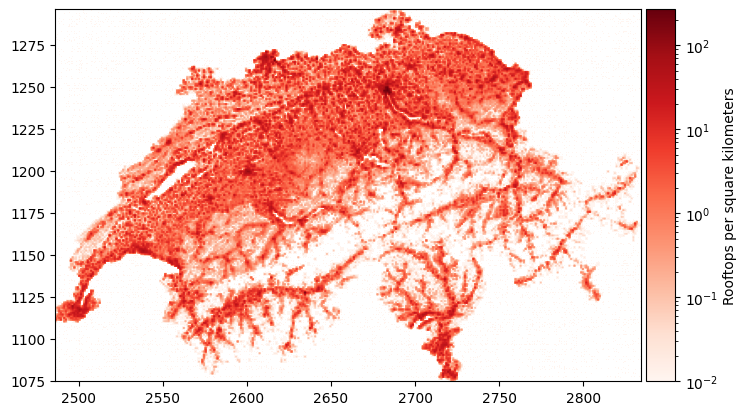

In [6]:
# Show density per square kilometer
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(
    histogram / 100,
    cmap="Reds",
    norm=colors.LogNorm(),
    origin="lower",
    extent=(i_min, i_max, j_min, j_max),
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("Rooftops per square kilometers")
plt.show()

In [19]:
# Consider only cases where we have enough rooftops
threshold = 400
candidates = counts[counts >= threshold].index
len(candidates) / len(counts)

0.2122687135324035

In [20]:
# Check existing files
folder = "../data/swissimage/"
paths = [os.path.join(folder, name) for name in os.listdir(folder)]
existing_candidates = []
for path in paths:
    match = re.search(r"swissimage-dop10_\d+_(\d+)-(\d+)_", path)
    if match is not None:
        i = match.group(1)
        j = match.group(2)
        existing_candidates.append((int(i), int(j)))
len(existing_candidates)

0

In [21]:
# Load list
# Note: since some images may be associated to older years, we cannot predict the exact URL
url_df = pd.read_csv("../data/swissimage/url.csv", header=None, names=["url"])
url_df

,url
0,https://data.geo.admin.ch/ch.swisstopo.swissim...
1,https://data.geo.admin.ch/ch.swisstopo.swissim...
2,https://data.geo.admin.ch/ch.swisstopo.swissim...
3,https://data.geo.admin.ch/ch.swisstopo.swissim...
4,https://data.geo.admin.ch/ch.swisstopo.swissim...
...,...
42684,https://data.geo.admin.ch/ch.swisstopo.swissim...
42685,https://data.geo.admin.ch/ch.swisstopo.swissim...
42686,https://data.geo.admin.ch/ch.swisstopo.swissim...
42687,https://data.geo.admin.ch/ch.swisstopo.swissim...


In [22]:
# Extract coordinates
ij_df = url_df["url"].str.extract(r"swissimage-dop10_\d+_(?P<i>\d+)-(?P<j>\d+)").astype(int)
url_df = pd.concat([url_df, ij_df], axis=1).set_index(["i", "j"])

In [23]:
# Hopefully, we have pictures for the whole country
len(candidates.difference(url_df.index))

0

In [24]:
# Remove existing files from candidates
candidates = candidates.difference(existing_candidates)

# Keep only the available coordinates
candidates = candidates.intersection(url_df.index)

In [25]:
# Sample a few pictures
# Note: in this strategy, the rooftop density is NOT used to bias the selection, so that we also get rural areas
num_samples = 25
generator = np.random.default_rng(42)
selected_candidates = generator.choice(candidates, num_samples, replace=False)

In [26]:
# Download files
for i, j in tqdm(selected_candidates):
    url = url_df.loc[(i, j)]["url"]
    name = os.path.basename(url)
    path = f"../data/swissimage/{name}"
    response = requests.get(url)
    response.raise_for_status()
    with open(path, "wb") as file:
        file.write(response.content)

100%|██████████| 25/25 [01:47<00:00,  4.30s/it]
